# Table of Contents
 <p><div class="lev1"><a href="#評価指標"><span class="toc-item-num">1&nbsp;&nbsp;</span>評価指標</a></div>

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import numpy as np

%matplotlib inline

In [2]:
# blobsの中心をクラスタ数に基づいて自動生成する
cluster= 5
step = 10
samples = 1000
centers = [(x,x) for x in range(0, step*cluster, step)]
print(centers)

[(0, 0), (10, 10), (20, 20), (30, 30), (40, 40)]


In [51]:
def make_2ellipse(n_samples):
    np.random.seed(0)
    C = np.array([[0., -0.1], [1.7, .4]])
#    X1 = [np.dot(np.random.randn(n_samples, 2), C),]
    X = np.r_[np.dot(np.random.randn(n_samples, 2), C), .7 * np.random.randn(n_samples, 2) + np.array([-2, 2])]
    Y = np.r_[np.zeros(n_samples), np.ones(n_samples)]
    Y = Y.astype(np.int32)
    return (X, Y)

    
print(make_2ellipse(10))

print(datasets.make_blobs(n_samples=10))

(array([[ 0.68026725, -0.01634235],
       [ 3.80951844,  0.79848348],
       [-1.6613724 , -0.57766695],
       [-0.25730725, -0.15555173],
       [ 0.69801745,  0.17456129],
       [ 2.47226496,  0.56730505],
       [ 0.20684753, -0.02743377],
       [ 0.56724636,  0.08908341],
       [-0.34876905, -0.23147121],
       [-1.45196276, -0.37294507],
       [-3.78709287,  2.45753302],
       [-1.39489466,  1.48048449],
       [-0.41117176,  0.98194403],
       [-1.96796904,  1.8689713 ],
       [-0.92705455,  3.02855114],
       [-1.8915368 ,  2.26471376],
       [-2.62145002,  0.61344247],
       [-2.2435385 ,  2.10944428],
       [-1.13879652,  2.84166589],
       [-2.27112877,  1.78838807]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32))
(array([[-4.20108516, -3.16385888],
       [ 1.37575318, -0.79963786],
       [ 9.13315467, -8.32184495],
       [ 9.09501631, -8.31865695],
       [-4.94422834, -1.94829423],
       [ 0.89313027, -2.40860191],
    

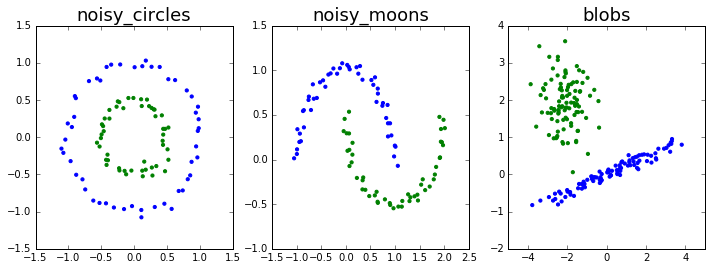

In [52]:
n_samples = 100
np.random.seed(0)


blobs = make_2ellipse(n_samples)
#blobs = datasets.make_blobs(n_samples=n_samples, random_state=8, cluster_std=2.0, centers=[(5,5),(20,5)])
#blobs = datasets.make_blobs(n_samples=samples, centers=centers, cluster_std=1.0)
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# no_structure = np.random.rand(n_samples, 2), None

#datasets_list = [noisy_circles, noisy_moons, blobs]
datasets_name = ["noisy_circles", "noisy_moons", "blobs"]


# データの正規化。これを実施しないとクラスタが楕円になる可能性がある
datasets_list = [
#   (StandardScaler().fit_transform(X), y) for X,y in [noisy_circles, noisy_moons, blobs]
   (X, y) for X,y in [noisy_circles, noisy_moons, blobs]
]

for dataset, dataset_name in zip(datasets_list, datasets_name):
    X, Y = dataset
    with open(dataset_name+".dat", "w") as f:
        for x, y in zip(X, Y):
            f.write(str(y)+","+str(x[0])+","+str(x[1])+"\r\n")
            
            

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
#plt.subplots_adjust(left=.00, right=.98, bottom=.001, top=.96, wspace=.05,
#                    hspace=.01)


plot_num = 1
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    X, y = dataset
    # normalize dataset for easier parameter selection
    #X = StandardScaler().fit_transform(X)

    plt.subplot(1, len(datasets_list), plot_num)
    plt.title(datasets_name[i_dataset], size=18)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y].tolist(), s=10)
    plot_num += 1
plt.savefig("data.png")

In [53]:
# データセットの分析
print("dataset")
print(X.shape)
print(X)

dataset
(200, 2)
[[ 0.68026725 -0.01634235]
 [ 3.80951844  0.79848348]
 [-1.6613724  -0.57766695]
 [-0.25730725 -0.15555173]
 [ 0.69801745  0.17456129]
 [ 2.47226496  0.56730505]
 [ 0.20684753 -0.02743377]
 [ 0.56724636  0.08908341]
 [-0.34876905 -0.23147121]
 [-1.45196276 -0.37294507]
 [ 1.11115161  0.51674642]
 [-1.26168053 -0.38330963]
 [-2.47242165 -0.80872173]
 [-0.31821255 -0.07944939]
 [ 2.49790991  0.43446559]
 [ 0.64287628  0.13577027]
 [-3.367354   -0.70354001]
 [ 0.26579325  0.0973308 ]
 [ 2.04404574  0.35792287]
 [-0.51391468 -0.08218842]
 [-2.41403049 -0.46315188]
 [ 3.31631817  0.95093718]
 [-0.74472631 -0.1242645 ]
 [ 1.3217336   0.43627568]
 [-0.36165848  0.07629367]
 [ 0.65773425  0.24430766]
 [-2.00707471 -0.42117236]
 [ 0.72816418  0.17415097]
 [ 0.51420223  0.11433704]
 [-0.61665998 -0.08166426]
 [-0.61124037 -0.07657522]
 [-2.93468042 -0.60919841]
 [-0.68302759 -0.17845499]
 [ 0.78672983  0.34813274]
 [ 0.08830717  0.11150799]
 [ 0.21927095 -0.02131589]
 [-2.099203

In [54]:
import json

from embedded_jubatus import Clustering
from jubatus.clustering.types import WeightedDatum
from jubatus.clustering.types import WeightedIndex
from jubatus.clustering.types import IndexedPoint
from jubatus.common import Datum


CONFIG = {
    'method': 'kmeans',
    'parameter': {
        'k' : 2,
        'seed' : 0,
    },
    'compressor_parameter': {
        'bucket_size': 2,
    },
    'compressor_method' : 'simple',
    'converter': {
        'num_filter_types': {},
        'num_filter_rules': [],
        'string_filter_types': {},
        'string_filter_rules': [],
        'num_types': {},
        'num_rules': [
            {'key': '*', 'type': 'num'}
        ],
        'string_types': {},
        'string_rules': [
            {'key': '*', 'type': 'space',
             'sample_weight': 'bin', 'global_weight': 'bin'}
        ]
    },
}

client = Clustering(CONFIG)

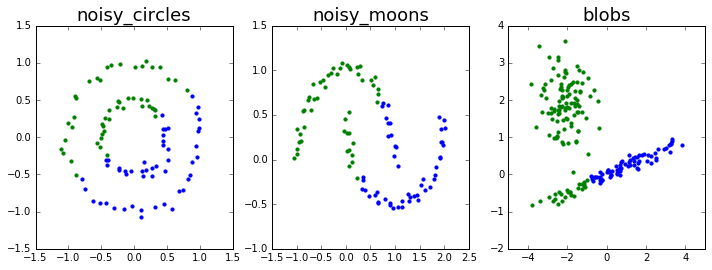

In [55]:
plot_num = 1
plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    plt.subplot(1, len(datasets_list), plot_num)

    plt.title(datasets_name[i_dataset], size=18)
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    #X = StandardScaler().fit_transform(X)

    i = 0
    client.clear()
    for row in X:
        client.push([IndexedPoint(str(i), Datum({'x' : row[0], 'y' : row[1]}))])
        i += 1
#    print("{0} push done.".format(datasets_name[i_dataset]))
    
    clusters = client.get_core_members_light()
        
    y = 0
    for cluster in clusters:
        for weighted_index in cluster:           
            plt.scatter(X[int(weighted_index.id), 0], X[int(weighted_index.id), 1], color=colors[y].tolist(), s=10)
        y += 1
    plot_num += 1
plt.savefig("kmeans.png")

In [56]:
CONFIG['method'] = 'gmm'
client = Clustering(CONFIG)

noisy_circles push done.
noisy_moons push done.
blobs push done.


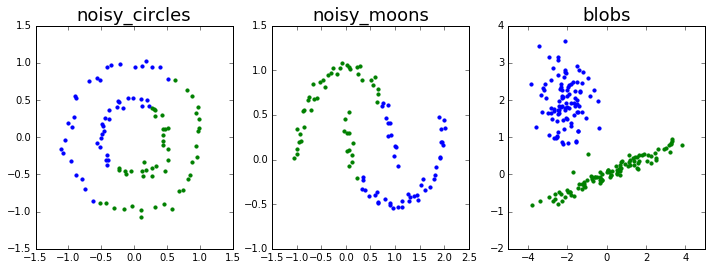

In [57]:
plot_num = 1
plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    plt.subplot(1, len(datasets_list), plot_num)

    plt.title(datasets_name[i_dataset], size=18)
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    #X = StandardScaler().fit_transform(X)

    i = 0
    client.clear()
    for row in X:
        client.push([IndexedPoint(str(i), Datum({'x' : row[0], 'y' : row[1]}))])
        i += 1
    print("{0} push done.".format(datasets_name[i_dataset]))
    
    clusters = client.get_core_members_light()
        
    y = 0
    for cluster in clusters:
        for weighted_index in cluster:           
            plt.scatter(X[int(weighted_index.id), 0], X[int(weighted_index.id), 1], color=colors[y].tolist(), s=10)
        y += 1
    plot_num += 1
plt.savefig("gmm.png")

In [60]:
CONFIG['method'] = 'dbscan'
if 'k' in CONFIG['parameter']:
    del(CONFIG['parameter']['k'])
if 'seed' in CONFIG['parameter']:
    del(CONFIG['parameter']['seed'])
CONFIG['parameter']['eps'] = 0.3
CONFIG['parameter']['min_core_point'] = 2
#print(CONFIG)
client = Clustering(CONFIG)

noisy_circles push done.
noisy_moons push done.
blobs push done.


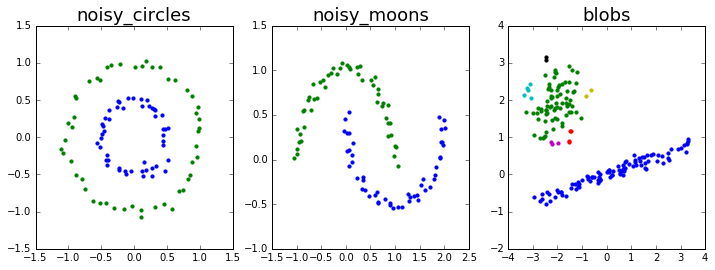

In [61]:
plot_num = 1
plt.figure(figsize=(len(datasets_list) * 2 + 6, 4))
for i_dataset, (dataset, dataset_name) in enumerate(zip(datasets_list, datasets_name)):
    plt.subplot(1, len(datasets_list), plot_num)

    plt.title(datasets_name[i_dataset], size=18)
    
    X, y = dataset
    # normalize dataset for easier parameter selection
    #X = StandardScaler().fit_transform(X)

    i = 0
    client.clear()
    for row in X:
        client.push([IndexedPoint(str(i), Datum({'x' : row[0], 'y' : row[1]}))])
        i += 1
    print("{0} push done.".format(datasets_name[i_dataset]))
    
    clusters = client.get_core_members_light()
        
    y = 0
    for cluster in clusters:
        for weighted_index in cluster:           
            plt.scatter(X[int(weighted_index.id), 0], X[int(weighted_index.id), 1], color=colors[y].tolist(), s=10)
        y += 1
    plot_num += 1
plt.savefig("dbscan.png")

# 評価指標
http://y-uti.hatenablog.jp/entry/2014/01/19/133936


In [12]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
labels_pred_all_correct = [0, 0, 0, 1, 1, 1]
labels_pred_alternative = [4, 4, 4, 5, 5, 5]
labels_pred2 = [0, 0, 0, 6, 6, 6]

print("adjusted rand index")
print(metrics.adjusted_rand_score(labels_true, labels_pred))
print(metrics.adjusted_rand_score(labels_true, labels_pred_all_correct))
print(metrics.adjusted_rand_score(labels_true, labels_pred_alternative))
print(metrics.adjusted_rand_score(labels_true, labels_pred2))

print("Mutual information based score")
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred_all_correct))
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred_alternative))
print(metrics.adjusted_mutual_info_score(labels_true, labels_pred2))

adjusted rand index
0.242424242424
1.0
1.0
1.0
Mutual information based score
0.225042310598
1.0
1.0
1.0
